In [1]:
from fastai.tabular import * 
from fastai_bayesian_nn.custom_dropout import CustomDropout, switch_custom_dropout, convert_layers
from fastai_bayesian_nn.bayesian import (entropy, BALD, uncertainty_best_probability,
                      get_preds_sample, plot_hist_groups, top_k_uncertainty)

In [2]:
path = untar_data(URLs.ADULT_SAMPLE)
path

PosixPath('/home/danywin/.fastai/data/adult_sample')

In [3]:
df = pd.read_csv(path/'adult.csv')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


In [4]:
positive_idx = df.loc[df.salary == ">=50k"].index

negative_idx = df.loc[df.salary != ">=50k"].index

n = len(positive_idx) // 2
positive = np.random.choice(positive_idx,n,replace=False)

negative = np.random.choice(negative_idx,n,replace=False)

train_idx = np.concatenate([negative,positive])

valid_idx = df.index[~np.isin(df.index,train_idx)]

In [5]:
procs = [FillMissing, Categorify, Normalize]

In [6]:
# valid_idx = range(len(df)-2000, len(df))

In [7]:
dep_var = 'salary'
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

In [8]:
data = TabularDataBunch.from_df(path, df, dep_var, valid_idx=valid_idx, procs=procs, cat_names=cat_names)
print(data.train_ds.cont_names)  # `cont_names` defaults to: set(df)-set(cat_names)-{dep_var}

['hours-per-week', 'education-num', 'fnlwgt', 'age', 'capital-gain', 'capital-loss']


In [9]:
learn = tabular_learner(data, layers=[200,100],ps=[0.10,0.05], emb_szs={'native-country': 10}, metrics=accuracy)


In [10]:
get_args = lambda dp : {"p" : dp.p}

In [11]:
convert_layers(learn.model,nn.Dropout,CustomDropout,get_args)

In [12]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(9, 5)
    (1): Embedding(17, 8)
    (2): Embedding(8, 5)
    (3): Embedding(16, 8)
    (4): Embedding(7, 5)
    (5): Embedding(6, 4)
    (6): Embedding(3, 3)
    (7): Embedding(42, 10)
    (8): Embedding(3, 3)
  )
  (emb_drop): CustomDropout(p=0.0, activate=True)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=57, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): CustomDropout(p=0.1, activate=True)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): CustomDropout(p=0.05, activate=True)
    (8): Linear(in_features=100, out_features=2, bias=True)
  )
)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


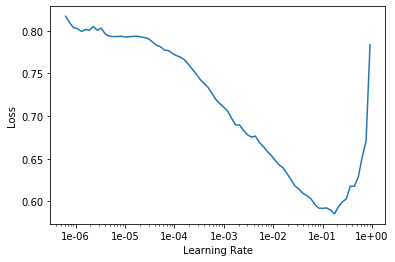

In [13]:
learn.lr_find()
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.434918,0.422791,0.781886,00:02
1,0.421274,0.490533,0.716112,00:02
2,0.404094,0.424859,0.771773,00:02
3,0.377173,0.410617,0.794952,00:02
4,0.372071,0.421595,0.779054,00:02


In [15]:
switch_custom_dropout(learn.model,False,True)

Current active : True
Switching to : False
Current active : True
Switching to : False
Current active : True
Switching to : False


In [16]:
switch_custom_dropout(learn.model,True,True)

Current active : False
Switching to : True
Current active : False
Switching to : True
Current active : False
Switching to : True


In [17]:
pred,y = get_preds_sample(learn)

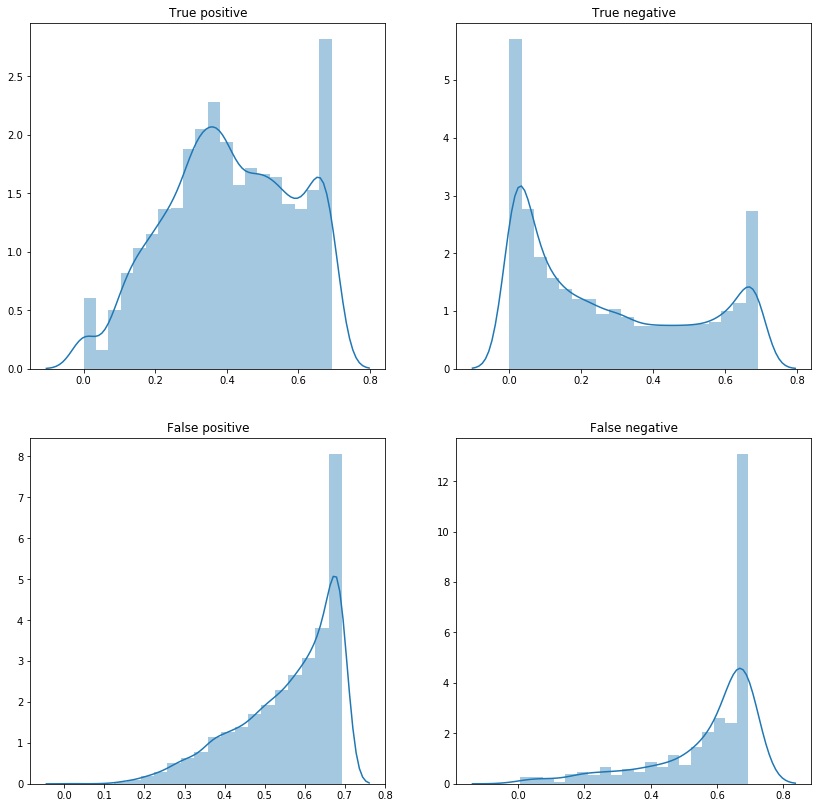

In [18]:
plot_hist_groups(pred,y,entropy,bins=20,figsize=(14,14))

In [20]:
raw_pred,y = get_preds_sample(learn,activ= lambda x : x)

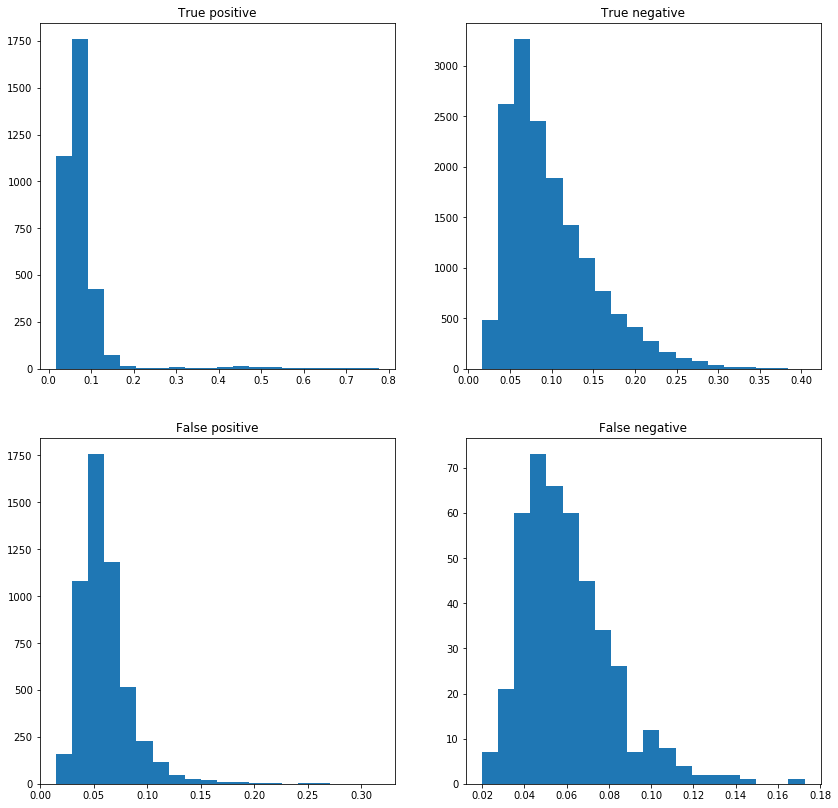

In [21]:
plot_hist_groups(raw_pred,y,uncertainty_best_probability,bins=20,figsize=(14,14))

In [20]:
H = entropy(pred)
idx = top_k_uncertainty(H,reverse=True)
learn.data.valid_ds[idx]

LabelList (5 items)
x: TabularList
age                      -0.357388
workclass                  Private
fnlwgt                    0.793751
education             Some-college
education-num            -0.227131
marital-status       Never-married
occupation                   Sales
relationship         Not-in-family
race                         White
sex                           Male
capital-gain             -0.201885
capital-loss             -0.259806
hours-per-week            0.654366
native-country       United-States
salary                        <50k
education-num_na             False
Name: 9118, dtype: object,age                          0.335357
workclass                     Private
fnlwgt                       -0.24207
education                Some-college
education-num               -0.227131
marital-status               Divorced
occupation           Transport-moving
relationship            Not-in-family
race                            White
sex                              Male

In [23]:
x = learn.data.train_ds.x[0]

In [25]:
x.classes

OrderedDict([('workclass',
              array(['#na#', ' ?', ' Federal-gov', ' Local-gov', ' Private', ' Self-emp-inc', ' Self-emp-not-inc', ' State-gov',
                     ' Without-pay'], dtype=object)),
             ('education',
              array(['#na#', ' 10th', ' 11th', ' 12th', ' 1st-4th', ' 5th-6th', ' 7th-8th', ' 9th', ' Assoc-acdm', ' Assoc-voc',
                     ' Bachelors', ' Doctorate', ' HS-grad', ' Masters', ' Preschool', ' Prof-school', ' Some-college'], dtype=object)),
             ('marital-status',
              array(['#na#', ' Divorced', ' Married-AF-spouse', ' Married-civ-spouse', ' Married-spouse-absent', ' Never-married',
                     ' Separated', ' Widowed'], dtype=object)),
             ('occupation',
              array(['#na#', ' ?', ' Adm-clerical', ' Armed-Forces', ' Craft-repair', ' Exec-managerial', ' Farming-fishing',
                     ' Handlers-cleaners', ' Machine-op-inspct', ' Other-service', ' Priv-house-serv', ' Prof-specia